# Pitstops and their Impact on Race Outcome
We will be exploring pitstop data from F1 seasons 2018-2023 and looking at how they determine the outcome of the races

## STEP 1 - Loading the Data & Libraries

In [1]:
# Let us start by importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.model_selection as model_selection

# Load the datasets
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
pit_stops = pd.read_csv('data/pit_stops.csv', dtype={'milliseconds': 'int'})

# Display the first few rows of the dataset
races.head(), results.head(), pit_stops.head() 

(   raceId  year  round  circuitId                   name        date  \
 0       1  2009      1          1  Australian Grand Prix  2009-03-29   
 1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
 2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
 3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
 4       5  2009      5          4     Spanish Grand Prix  2009-05-10   
 
        time                                                url fp1_date  \
 0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
 1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
 2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   
 3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...       \N   
 4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...       \N   
 
   fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
 0       \N       \N       \N

## STEP 2 - Filtering the Data
We are only interested in data from seasons 2018-2023 so let us try to filter the dataset

In [2]:
# Filtering the dataset for years 2018 to 2023
races_2018_2023 = races[(races['year'] >= 2018) & (races['year'] <= 2023)]
# Dropping unnecessary columns
races_2018_2023.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'url'], inplace=True)

# Getting the raceId for the years 2018 to 2023
raceIds_2018_2023 = races_2018_2023['raceId'].unique()

# Filtering pit_stops & results dataset with the raceIds from 2018 to 2023
pit_stops_2018_2023 = pit_stops[pit_stops['raceId'].isin(raceIds_2018_2023)]
results_2018_2023 = results[results['raceId'].isin(raceIds_2018_2023)]

# Display the shape of the filtered datasets
races_2018_2023.shape, pit_stops_2018_2023.shape, results_2018_2023.shape


C:\Users\Salar Salim\AppData\Local\Temp\ipykernel_11688\1125854008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_2018_2023.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'url'], inplace=True)


((125, 7), (3838, 7), (2300, 18))

## STEP 3 - Cleaning the Datasets
Now that we have the filtered data we can carry on with cleaning the data by handling missing values and outliers

In [3]:
# Check for missing values in the filtered datasets
missing_values_races = races_2018_2023.isnull().sum()
missing_values_results = results_2018_2023.isnull().sum()
missing_values_pit_stops = pit_stops_2018_2023.isnull().sum()

missing_values_races, missing_values_results, missing_values_pit_stops

(raceId       0
 year         0
 round        0
 circuitId    0
 name         0
 date         0
 time         0
 dtype: int64,
 resultId           0
 raceId             0
 driverId           0
 constructorId      0
 number             0
 grid               0
 position           0
 positionText       0
 positionOrder      0
 points             0
 laps               0
 time               0
 milliseconds       0
 fastestLap         0
 rank               0
 fastestLapTime     0
 fastestLapSpeed    0
 statusId           0
 dtype: int64,
 raceId          0
 driverId        0
 stop            0
 lap             0
 time            0
 duration        0
 milliseconds    0
 dtype: int64)

There are no missing values, however some have been filled with '/N' indicating a null value. Normally we would have to inspect, replace or in some instances remove those from out dataset because they could skew the analysis in many ways, but in this instance we're keeping them because for the datasets in question they signify that the racer has dropped out of the race for various reasons. Alternatively we could replace them with a numerical value for further analysis such as drop out percentage etc.

Let us visualize the data in the form of histograms, boxplots and scatterplots to help further our analysis


Descriptive statistics provide a summary of the main features of our data, giving us a quick overview of what the data looks like.

Key Metrics:
Mean: The average value of a dataset.
Median: The middle value when the data is sorted in order.
Standard Deviation (Std): Measures how spread out the values are from the mean.
Minimum (Min): The smallest value in the dataset.
Maximum (Max): The largest value in the dataset.
Count: The number of observations or data points.

In [4]:
# Checking the descriptive statistics of the filtered datasets
pit_stops_2018_2023.describe(), results_2018_2023.describe()

(            raceId     driverId         stop          lap  milliseconds
 count  3838.000000  3838.000000  3838.000000  3838.000000  3.838000e+03
 mean   1052.212611   677.959093     1.634966    26.124023  1.203078e+05
 std      34.592413   322.770085     0.870204    15.595862  3.858480e+05
 min     989.000000     1.000000     1.000000     1.000000  1.397300e+04
 25%    1023.000000   815.000000     1.000000    14.000000  2.211850e+04
 50%    1054.000000   832.000000     1.000000    25.000000  2.391700e+04
 75%    1082.000000   845.000000     2.000000    37.000000  2.853875e+04
 max    1110.000000   858.000000     6.000000    78.000000  3.069017e+06,
            resultId       raceId     driverId  constructorId         grid  \
 count   2300.000000  2300.000000  2300.000000    2300.000000  2300.000000   
 mean   24934.737391  1048.121739   677.193478      77.624348    10.119130   
 std      665.141029    35.392326   322.250443      87.089409     5.825181   
 min    23782.000000   989.000

c:\Users\Salar Salim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lap', ylabel='Count'>

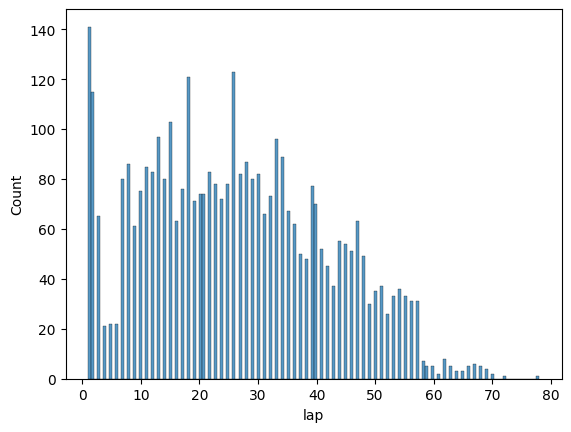

In [5]:

# Histogram for Lap Distribution in Pit Stops
sns.histplot(pit_stops_2018_2023['lap'], bins=150)


We can see that most drivers have a pit stop around the first two laps. This can be caused by faulty equipment, accidents or a change in strategy.

Apart from the first two laps the data shows signs of normal distribution. We can overlay the normal distribution curve to check

c:\Users\Salar Salim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


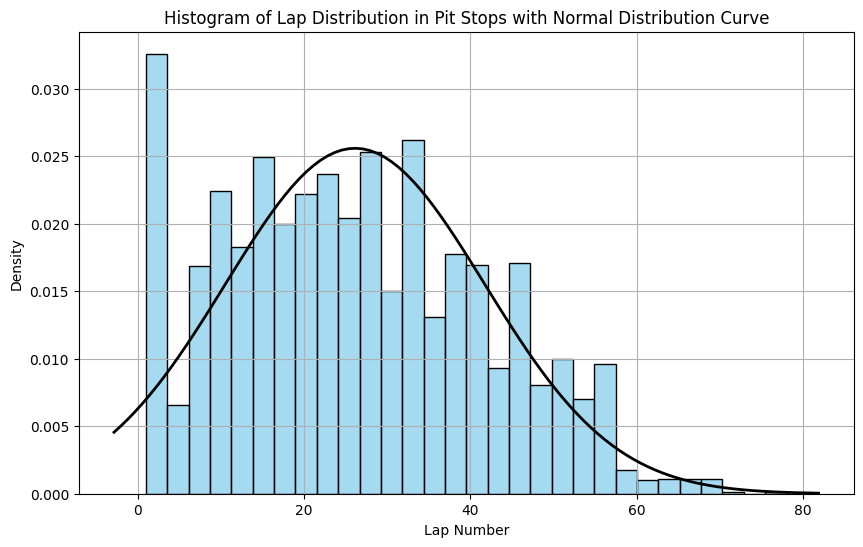

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(10, 6))
sns.histplot(pit_stops_2018_2023['lap'], kde=False, stat="density", bins=30, color='skyblue', edgecolor='black')

# Overlay the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(pit_stops_2018_2023['lap']), np.std(pit_stops_2018_2023['lap']))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Lap Distribution in Pit Stops with Normal Distribution Curve')
plt.xlabel('Lap Number')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Let us take a look at how the milliseconds, meaning the duration of the stops in ms is distributed

c:\Users\Salar Salim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(10000.0, 100000.0)

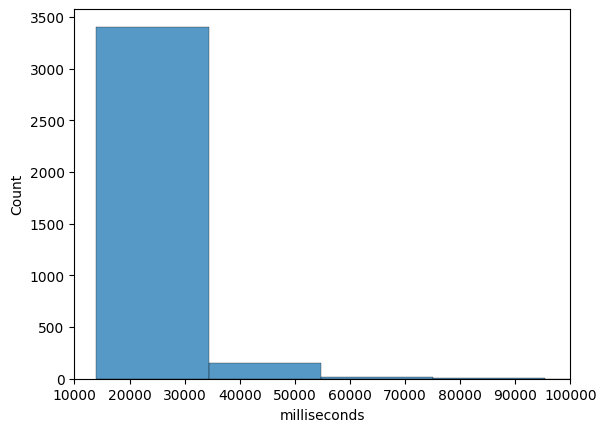

In [7]:
sns.histplot(pit_stops_2018_2023['milliseconds'], bins=150)
plt.xlim([10000, 100000])

(10000.0, 100000.0)

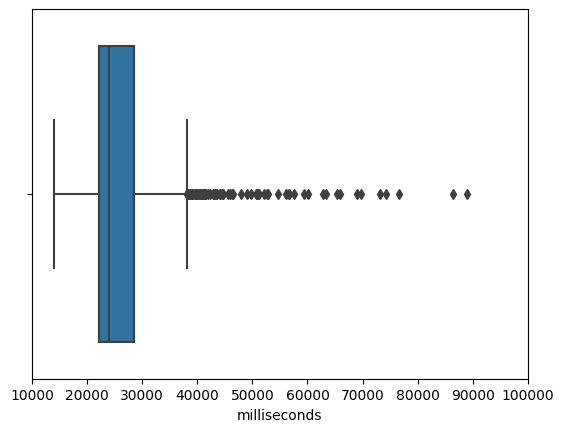

In [8]:
sns.boxplot(x='milliseconds', data=pit_stops_2018_2023)
plt.xlim([10000, 100000])

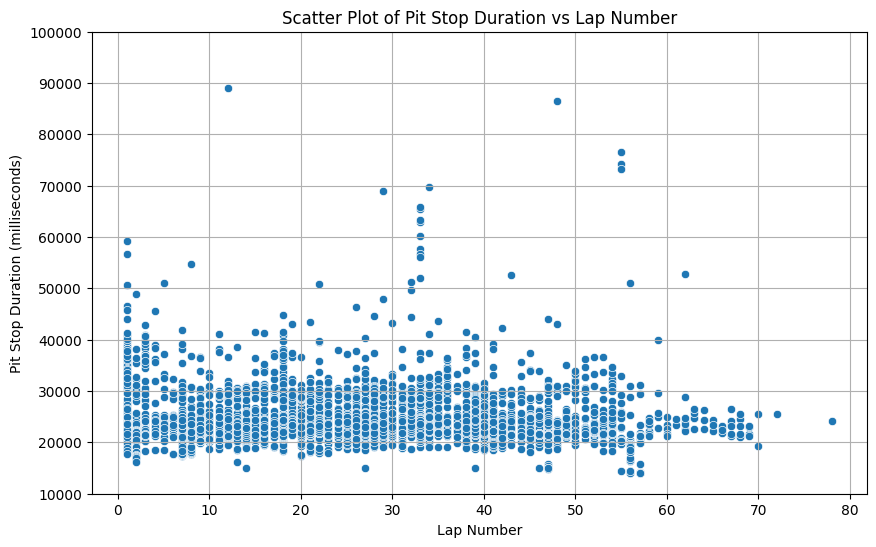

In [9]:
# Scatter plot for Pit Stop Duration vs Lap Number
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pit_stops_2018_2023, x='lap', y='milliseconds')
plt.title('Scatter Plot of Pit Stop Duration vs Lap Number')
plt.xlabel('Lap Number')
plt.ylabel('Pit Stop Duration (milliseconds)')
plt.ylim(10000, 100000)
plt.grid(True)
plt.show()

In [10]:
# the median pit stop duration
median_pit_stop = pit_stops_2018_2023['milliseconds'].median()
median_pit_stop

23917.0

We can see from the boxplot that pitstops above 40.000 ms are considered outliers. The outliers are however better visualized in the scatterplot were we can determine that anything above 50.000 ms is a more precise way to determine what are outliers. That's a duration of 50 seconds for a pitstop, which is unusually long especially considering the median is around 23 seconds.
So let us proceed with removing pitstops above 50.000 ms 

In [11]:
# removing outliers from the pit stop dataset anything above 50,000 milliseconds
pit_stops_2018_2023 = pit_stops_2018_2023[pit_stops_2018_2023['milliseconds'] <= 50000]

# removing time column from the pit stops dataset
pit_stops_2018_2023.drop(columns=['time'], inplace=True)

# Checking the descriptive statistics of the pit stops dataset
pit_stops_2018_2023.describe()

,raceId,driverId,stop,lap,milliseconds
count,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000
mean,1050.946731,678.552142,1.591319,26.521984,24683.097238
std,35.117560,322.002900,0.813859,15.182262,4491.171732
min,989.000000,1.000000,1.000000,1.000000,13973.000000
25%,1020.000000,815.000000,1.000000,14.000000,22022.000000
50%,1052.000000,832.000000,1.000000,26.000000,23655.500000
75%,1082.000000,845.000000,2.000000,38.000000,26208.500000
max,1110.000000,858.000000,6.000000,78.000000,49729.000000


Now let us merge the data from pit stops and results into one dataset and choose the columns we want to investigate further to see if there is basis for making predictions on outcome or otherwise.

In [12]:
# Merge the datasets based on raceId and driverId
merged_data = pd.merge(results_2018_2023, pit_stops_2018_2023, on=['raceId', 'driverId'])

# rename milliseconds_x to milliseconds_lap and milliseconds_y to milliseconds_pit
merged_data.rename(columns={'milliseconds_x': 'milliseconds_lap', 'milliseconds_y': 'milliseconds_pit'}, inplace=True)

# Select relevant columns for further analysis
relevant_columns = ['raceId', 'driverId', 'stop', 'lap', 'milliseconds_pit', 'positionOrder', 'points', 'laps']
merged_data = merged_data[relevant_columns]

# Display the merged dataset
merged_data.head()


,raceId,driverId,stop,lap,milliseconds_pit,positionOrder,points,laps
0,989,20,1,26,21787,1,25.0,58
1,989,1,1,19,21821,2,18.0,58
2,989,8,1,18,21421,3,15.0,58
3,989,817,1,26,21440,4,12.0,58
4,989,4,1,26,22573,5,10.0,58


In [13]:
# Save merged dataset to a csv file
merged_data.to_csv('data/merged_data.csv', index=False)
# Descriptive statistics of the merged dataset
merged_data.describe()

,raceId,driverId,stop,lap,milliseconds_pit,positionOrder,points,laps
count,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000
mean,1050.946731,678.552142,1.591319,26.521984,24683.097238,10.075254,5.296787,59.184329
std,35.117560,322.002900,0.813859,15.182262,4491.171732,5.487739,7.341915,11.313527
min,989.000000,1.000000,1.000000,1.000000,13973.000000,1.000000,0.000000,2.000000
25%,1020.000000,815.000000,1.000000,14.000000,22022.000000,5.000000,0.000000,52.000000
50%,1052.000000,832.000000,1.000000,26.000000,23655.500000,10.000000,1.000000,58.000000
75%,1082.000000,845.000000,2.000000,38.000000,26208.500000,15.000000,10.000000,69.000000
max,1110.000000,858.000000,6.000000,78.000000,49729.000000,20.000000,26.000000,87.000000


To understand the relationship between the different variables we will calculate the correlation matrix and visualize it in a heatmap

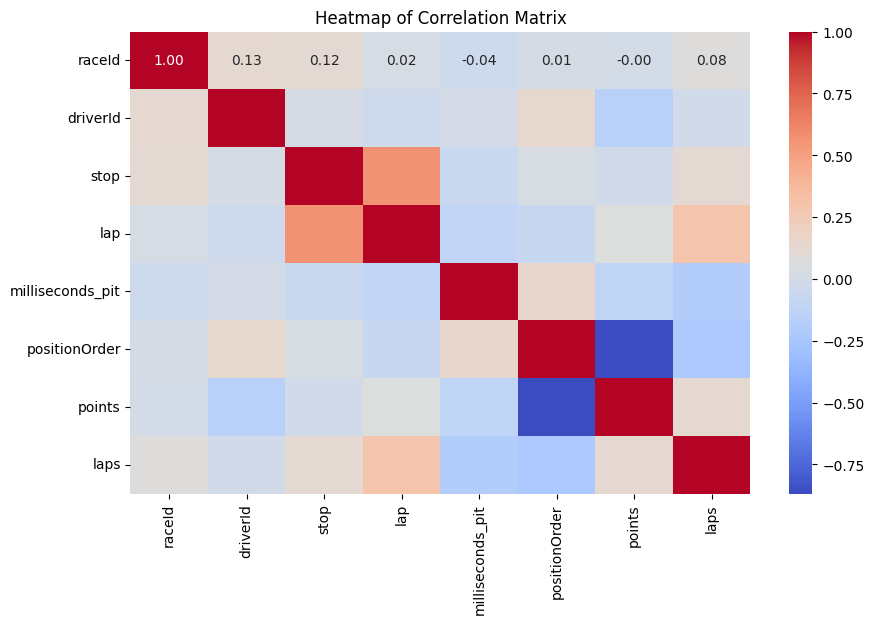

In [14]:
# Correlation matrix of the merged dataset
correlation_matrix = merged_data.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()

From this we can observe a slight positive correlation in milliseconds and positionOrder and a high negative correlation in points and positionOrder. This is natural because a higher 'positionOrder' value (indicating a lower finish, e.g., 10th place) is associated with fewer points.

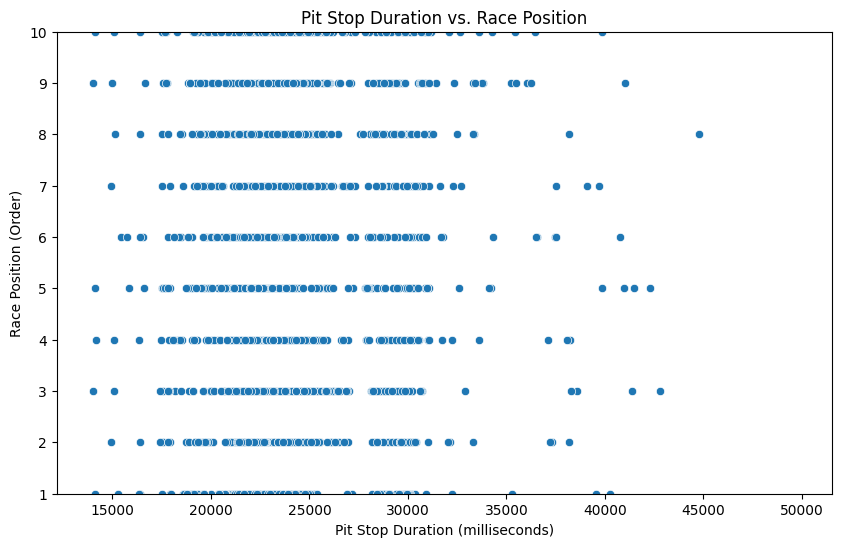

In [15]:
# Relationship between pit stop duration and race position
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milliseconds_pit', y='positionOrder', data=merged_data)
plt.ylim(1, 10)
plt.title('Pit Stop Duration vs. Race Position')
plt.xlabel('Pit Stop Duration (milliseconds)')
plt.ylabel('Race Position (Order)')
plt.show()

From what we can gather it seems as if the best pit stop strategy for a 1st place outcome is to be quick and precise using no longer than 25 seconds. I will try to build a predictive model to forecast the race outcome using all the data. For this I will use the Random Forest Model.

Race outcomes can be influenced by a variety of factors, including driver skill, car performance, pit stop strategy, and weather conditions. These interactions are often non-linear and complex, which Random Forest can model effectively.

We use classification because our goal is to predict discrete race positions. We chose the Random Forest model because it effectively handles the complexity and variability in our dataset, providing accurate and robust predictions. Additionally

Given the characteristics of the dataset and the advantages of Random Forest, it is a robust choice for predicting race outcomes. The model's ability to handle complex interactions, provide feature importance, and reduce overfitting makes it well-suited for this task.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features and target variable
features = merged_data[['driverId', 'stop', 'lap', 'milliseconds_pit', 'points', 'laps']]
target = merged_data['positionOrder']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict race positions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)



In [17]:
# Display accuracy
accuracy

0.5924882629107981

The classification report shows how well the Random Forest model predicts each race position using three key metrics: precision, recall, and F1-score.

Precision: This tells us how many of the predicted race positions were correct. High precision means the model is good at predicting the correct positions.
Recall: This shows how many of the actual race positions were found by the model. High recall means the model doesn't miss many actual positions.
F1-score: This is a combined measure of precision and recall, useful for understanding the overall performance when both precision and recall are important.


In [18]:
# Display classification report
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        61
           4       1.00      1.00      1.00        55
           5       1.00      1.00      1.00        52
           6       1.00      0.98      0.99        53
           7       0.98      1.00      0.99        50
           8       1.00      0.98      0.99        65
           9       0.98      1.00      0.99        45
          10       1.00      1.00      1.00        52
          11       0.11      0.13      0.12        52
          12       0.14      0.11      0.12        64
          13       0.16      0.16      0.16        62
          14       0.15      0.15      0.15        66
          15       0.21      0.31      0.25        51
          16       0.20      0.15      0.17        61
          17       0.15      0.14      0.15        56
          18       0.13    

The classification report indicates that the model is highly precise and accurate in predicting the higher positions (positions 1 to 10), but it struggles significantly with predicting the lower positions (positions 11 to 20).

## MAE & MSE
The Mean Absolute Error measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average of the absolute differences between predicted values and actual values.

In [19]:
# Mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

1.136150234741784

On average, the predictions of the regression model are off by about 1.14 units from the actual values. This means the typical error made by the model is approximately 1.14 units.

The Mean Squared Error measures the average of the squares of the errors. It is the average squared difference between the estimated values and the actual value. The squaring of the differences means that larger errors are penalized more heavily than smaller ones.

In [20]:
# Mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse

4.4

The average of the squared errors is 4.4. This means that the average squared difference between the predicted values and the actual values is 4.4 units squared. Because MSE squares the errors, it tends to amplify larger errors.

An MAE of 1.136 suggests that the model's predictions are generally close to the actual values, with an average error of about 1.14 units. However, the MSE of 4.4 indicates that there are some larger errors that the model makes, which should be investigated further to understand why these larger errors occur and how they might be mitigated.